In [1]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools

from IPython.display import HTML
def show_df(df):
    return HTML(df.to_html(notebook=True))

# Function: implements murcko scaffold algorithm as originally described

In [2]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdchem

def GetTrueScaffold(mol,generic=False):
    #Not sure if hybridisation of dummy atom is correct
    #Not sure on properties
    #Seems to work as desired
    """
    Takes RDKit mol object
    Returns mol object of the murcko scaffold with original algorithm
    Stereochemistry is lost
    """
    mol = MurckoScaffold.GetScaffoldForMol(mol)
    atom_to_remove = []
    atom_to_clean = []
    
    for a in mol.GetAtoms():
        #Remove chirality
        mol.GetAtomWithIdx(a.GetIdx()).SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
        
        #For atoms bonded to only one other atom, these must be removed
        if len(a.GetBonds()) == 1:
            #Get index of atom to delete and append to deletion list
            atom_to_remove.append(a.GetIdx())

    #If there are atoms to delte
    if len(atom_to_remove) > 0:
        #Create an editable molecule (now RW)
        emol = rdchem.RWMol(mol)
        #Every time an atom is delted the index changes
        #Deletion list must be reversed to avoid rogue deletions
        for a in atom_to_remove[::-1]:
            #Remove atom by index a
            emol.RemoveAtom(a)
    #If the molecule is already the correct murcko scaffold set emol = mol
    else:
        emol = mol
    
    #This line used to cause errors
    #SanitizeMol(emol) often failed due to aromaticity
    #Attempts to solve this included replacing previously bonded atoms with the
    #wild card *
    #It seems clearing aromatic flags solved the issue
    try:
        #Clearing aromatic flags seems to fix everything
        Chem.Kekulize(emol,clearAromaticFlags=True)
        Chem.SanitizeMol(emol)
    except:
        #Error
        #Will show the input molecule and attempted editted molecule (before sanitization attempt)
        display("Input Mol")
        display(mol)
        display("Output Emol")
        display(emol)
        raise ("Error in santisation of new molecule")
        return False
    
    #The above procedure will remove all remaining decorating groups on scaffold
    #In some cases (like sulfonyl) this will leave an aliphatic chain
    #Additional application of MurckoScaffold algorithm is needed
    #However the RDKit implementation is sufficient 
    emol = MurckoScaffold.GetScaffoldForMol(emol)
    
    #If the generic scaffold is desired (Flag), make generic
    if generic:
        emol = MurckoScaffold.MakeScaffoldGeneric(emol)

    #Return the molecule
    return emol

# Replace atoms present in murcko scaffold with wild card. All side chains remain intact

In [18]:
def CleanScaffold(mol,seed=None):
    """
    input:
        RDKit mol
    param:
        seed: RDKit smarts mol. If provided, only the substructure matching the seed will be
            replaced by wild card, not entire murcko. This might be desired in cases of scaffold hopping. 
    returns:
        RDKit mol with backbone replaced by wildcard atoms
    """
    #Note, orignal implentation replaces backbone with carbon, however this caused issues in cases of hypervalency
    if not seed:
        seed = GetTrueScaffold(mol)
    for atom_idx in mol.GetSubstructMatch(seed):
        mol.GetAtomWithIdx(atom_idx).SetAtomicNum(0)
    return mol

# Function: from a pair of molecules, find the fragments. Optional seed (smarts string) to accelerate substructure search. Flag "clean_scaffold" will replace all murcko scaffold atoms in mol with wildcard, neccessary for succesfull fragment finding 

In [19]:
#This will fail in cases where the seed contains hetero atoms
#and the scaffold has been cleaned
from rdkit.Chem import ReplaceCore

def GetFragmentsFromPair(mol1,mol2,seed="",clean_scaffold=False):
    """
    inputs:
        mol1: RDKit mol
        mol2: RDKit mol
    params:
        seed: RDKit smarts mols
        clean_scaffold: if true, replace all atoms in scaffold with wildcard
        
    returns:
        frags1: RDKit mol object of fragments from mol1
        frags2: RDKit mol object of fragments from mol2
    """

    if clean_scaffold:
        mol1 = CleanScaffold(mol1,seed=seed)
        mol2 = CleanScaffold(mol2,seed=seed)
    
    #Not the best code here, not not sure how to solve mcs issue
    #Ideally would just pass seed=None into the mcs search when a seed is not provided, however
    #This did not work. As such need to run the if statement, howver this is code duplication and
    #No desired
    if seed != "":
        mcs = FindMCS([mol1, mol2],
                         timeout=1,
                         ringMatchesRingOnly=True,
                         completeRingsOnly=True,
                         seedSmarts=Chem.MolToSmarts(seed),
                          #atomCompare=AtomCompare.CompareAnyHeavyAtom,
                          #ringCompare=RingCompare.IgnoreRingFusion,
                          bondCompare=BondCompare.CompareAny,
                        )
    else:
        mcs = FindMCS([mol1, mol2],
                         timeout=1,
                         ringMatchesRingOnly=True,
                         completeRingsOnly=True,
                         #seedSmarts=Chem.MolToSmarts(seed),
                          #atomCompare=AtomCompare.CompareAnyHeavyAtom,
                          #ringCompare=RingCompare.IgnoreRingFusion,
                          bondCompare=BondCompare.CompareAny,
                        )
    
    
    #From found mcs (smarts object), return the RDKit smarts mol
    mcs = Chem.MolFromSmarts(mcs.smartsString)
    
    #Replace the core of mol1 and mol2 by mcs, hence isolating modified fragments
    frags1 = ReplaceCore(mol1,mcs,labelByIndex=True)
    frags2 = ReplaceCore(mol2,mcs,labelByIndex=True)
    
    #Return two rdkit mol objects containing all fragments
    return frags1,frags2

In [20]:
def GetFragments(mol, seed="", clean_scaffold=False):
    """
    input:
        mol: RDKit mol
    params:
        Seed: RDKit smarts mol
        clean_scaffold: If true, replace atoms in mol backbone with wildcard
            If seed is passed, this will be used for cleaning
            
    returns:
        Sidechain fragments of mol, indexed with respect to 
    """
    
    #Note: issues may arrise if cleaning
    #Cleaning only really needed when considering pairs
    
    if not seed:
        seed = GetTrueScaffold(mol)
    
    if clean_scaffold:
        mol = CleanScaffold(mol,seed=seed)
        
    fragments = ReplaceCore(mol,
                            seed,
                            labelByIndex=True
                           )
    return fragments

# Function: from a pair of rdkit mol fragments, find the fragments which are not shared, ie have changed

In [6]:
def UniqueFragments(frags1,frags2,return_single=False):
    """
    input:
        frags1: RDKit mol, core removed leaving only fragments
        frags2: RDKit mol, core removed leaving only fragments
    param:
        return_single: (bool), if true: combines the resulting fragment
        set into one array and returns together. Might be good for scoring
        
    returns:
        unique1: list of RDKit mol fragments present on mol1 but not mol2
        unique2: list of RDKit mol fragments present on mol2 but nor mol1
    """
    frags1=Chem.GetMolFrags(frags1, asMols=True)
    frags2=Chem.GetMolFrags(frags2, asMols=True)
    
    hash1 = [MolHash(x,HashFunction.CanonicalSmiles) for x in frags1]
    hash2 = [MolHash(x,HashFunction.CanonicalSmiles) for x in frags2]
    
    hash1 = set(hash1)
    hash2 = set(hash2)
    
    unique1 = hash1-hash2
    unique2 = hash2-hash1
    
    if return_single:
        return list(unique1.union(unique2))
    else:
        return list(unique1), list(unique2)

# Function: get seed

In [7]:
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.rdFMCS import AtomCompare
from rdkit.Chem.rdFMCS import RingCompare
from rdkit.Chem.rdFMCS import BondCompare

def GetSeed(mols, clean_scaffold=False):
    """
    input: array of RDKit mols
    param: clean_scaffold (bool), if true: replace all
        atoms in murcko scaffold with wildcard (cleaning needed when scaffold
        atoms transform as this breaks RBFENN). If true, all subsequent comparsions need
        scaffold cleaning. 
        
    returns: RDkit smarts mols of seed for entire dataset
    """
    if clean_scaffold:
        new_mols = []
        for mol in mols:
            try:
                #This might be modifying molecule in place
                #find way to avoid this
                mol = CleanScaffold(mol)
                new_mols.append(mol)
            except:
                print("Error in cleaning molecule:")
                print("This molecule will be ignored in seed finding")
                display(mol)
                #raise ValueError("Error: mol could not be cleaned. Likely contains hypervalent atoms")
        mols = new_mols
    
    seed = FindMCS(mols, 
            atomCompare=AtomCompare.CompareAny,
            ringCompare=RingCompare.IgnoreRingFusion,
            bondCompare=BondCompare.CompareAny,
            #completeRingsOnly=True
            #threshold=0.8,#Much slower
           )
    
    return Chem.MolFromSmarts(seed.smartsString)

# Testing

In [8]:
moonshot_file = "../../covid_submissions_all_info.csv"
df = pd.read_csv(moonshot_file)
PandasTools.AddMoleculeColumnToFrame(df,'SMILES','Molecule')

/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3,6,7,9,10,11,12,13,14,15,18,19,27,28,29,30,31,32,33,34,35,36,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,66,67,69,70,71,72,73,74,75,76,84,85,86,87,89,90,91,92,93,94,95,96,104,105,106,107,109,110,111,112,113,114,115,116,124,125,126,127,129,130,131,132,133,134,135,136,144,145,146,147,149,150,151,152,153,154,155,156,164,165,166,167,169,170,171,172,173,174,175,176,184,185,186,187,189,190,191,192,193,194,195,196,204,205,206,207,209,210,211,212,213,214,215,216,224,225,226,227,229,230,231,232,233,234,235,236,244,245,246,247,249,253,254,255,256,257,258,259,275,276) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
[15:03:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:03:13] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:03

In [9]:
mol_cluster = []
with open("largest_generic_scaffold.csv","r") as readfile:
    for line in readfile.readlines():
        mol_cluster.append(line.strip())

In [10]:
mols = df.loc[df["CID"].isin(mol_cluster)]
mols = mols[["CID", "Molecule"]]

,CID,Molecule
8460,JAG-UCB-c61058a9-45,
8461,JAG-UCB-c61058a9-46,
9848,MAR-TRE-04c86cea-47,
13172,COM-UCB-1ef4e90e-1,
13208,VLA-UCB-1dbca3b4-14,

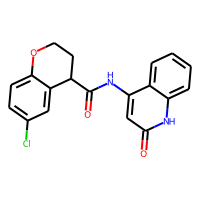
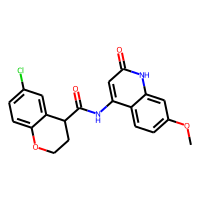
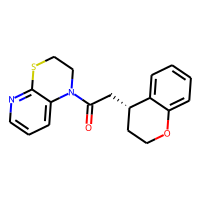
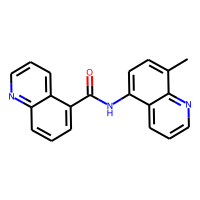
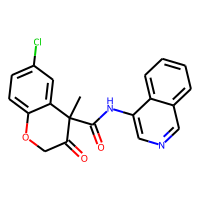

In [11]:
show_df(mols.head())

In [12]:
mols_array = [Chem.MolFromSmiles(Chem.MolToSmiles(x)) for x in list(mols["Molecule"])]
pairwise_subset = [(mols_array[i],mols_array[i+100]) for i in range(len(mols_array[:100]))]

mols_array_u = [Chem.MolFromSmiles(Chem.MolToSmiles(x)) for x in list(mols["Molecule"])]
pairwise_subset_u = [(mols_array_u[i],mols_array_u[i+100]) for i in range(len(mols_array[:100]))]

# Comparing MCS search with and without a seeding

In [13]:
import time

In [14]:
# This accelerated grafting ignores atoms which make up the murcko scaffold
# This means backbone transormations are ignored
# However this might help with subseqeuent RBFENN grafting is often grafting failed (or was not representitive)
# in cases where bacbone changed (as far as i'm aware)

In [59]:
(55**2 - 55)/2

1485.0

In [63]:
# Accelerated Grafting
#import test set
mols_subset = [Chem.MolFromSmiles(Chem.MolToSmiles(x)) for x in list(mols["Molecule"])[:50]]

t1 = time.time()
mcs_array_1 = []

#Preclean - Convert all backbone atoms to wild card
mols_subset = [CleanScaffold(x) for x in mols_subset]

#Get smarts seed from entire cleaned dataset
seed = GetSeed(mols_subset,clean_scaffold=False)
seed = Chem.MolToSmarts(seed)

#Do MCS search
for i in range(len(mols_subset)):
    for j in range(i):
        mol1 = mols_subset[i]
        mol2 = mols_subset[j]
        
        mcs = FindMCS([mol1, mol2],
                     timeout=1,
                     ringMatchesRingOnly=True,
                     completeRingsOnly=True,
                     seedSmarts=seed,
                      #atomCompare=AtomCompare.CompareAny,
                      #ringCompare=RingCompare.IgnoreRingFusion,
                      bondCompare=BondCompare.CompareAny,
                    )
        mcs_array_1.append(mcs)
t2 = time.time()
print(round(t2-t1, 3), "seconds")

0.48 seconds


In [135]:
i=1000
print("running n = ", i)

mols_subset = [Chem.MolFromSmiles(Chem.MolToSmiles(x)) for x in list(mols["Molecule"])[:i]]

t1 = time.time()
seed = GetSeed(mols_subset, clean_scaffold=False)#This is slowest step
t2 = time.time()

for i in range(len(mols_subset)):
    print(i)
    for j in range(i):
        GetFragmentsFromPair(mols_subset[i],mols_subset[j],seed=seed) 
t3 = time.time()

print("Molecules in set: ", len(mols_subset))
print("Pairwise comparsions : ", int((len(mols_subset)**2 - len(mols_subset))/2))
print("Seed found in", round(t2-t1, 3) ,"seconds")
print("time for pairwise search", round(t3-t2, 3), "seconds")
print("total time", round(t3-t1, 3), "seconds")

running n =  1000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272


In [ ]:
#Collecting run time stats
"""
n_size = []
n_pairs = []
seed_times = []
pair_times = []
total_times = []

for i in range(5,201, 5):
    print("running n = ", i)

    mols_subset = [Chem.MolFromSmiles(Chem.MolToSmiles(x)) for x in list(mols["Molecule"])[:i]]

    t1 = time.time()
    seed = GetSeed(mols_subset, clean_scaffold=False)#This is slowest step
    t2 = time.time()

    for i in range(len(mols_subset)):
        for j in range(i):
            GetFragmentsFromPair(mols_subset[i],mols_subset[j],seed=seed) 
    t3 = time.time()

    n_size.append(i)
    n_pairs.append(int(i**2 - i/2))
    seed_times.append(t2-t1)
    pair_times.append(t3-t2)
    total_times.append(t3-t1)

"""

"""
print("Molecules in set: ", len(mols_subset))
print("Pairwise comparsions : ", int((len(mols_subset)**2 - len(mols_subset))/2))
print("Seed found in", round(t2-t1, 3) ,"seconds")
print("time for pairwise search", round(t3-t2, 3), "seconds")
print("total time", round(t3-t1, 3), "seconds")
"""

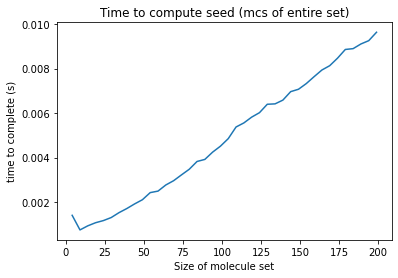

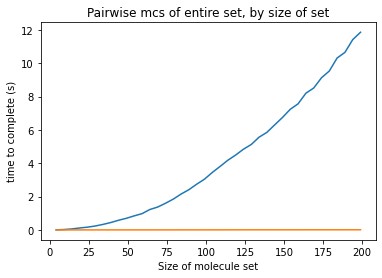

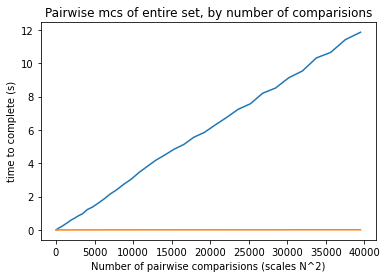

'\nn_size\nn_pairs\nseed_times\npair_times\ntotal_times\n'

In [136]:
import matplotlib.pyplot as plt

plt.plot(n_size, seed_times)
plt.title("Time to compute seed (mcs of entire set)")
plt.ylabel("time to complete (s)")
plt.xlabel("Size of molecule set")
plt.show()

plt.plot(n_size, pair_times)
plt.plot(n_size, seed_times)
plt.title("Pairwise mcs of entire set, by size of set")
plt.ylabel("time to complete (s)")
plt.xlabel("Size of molecule set")
plt.show()

plt.plot(n_pairs, pair_times)
plt.plot(n_pairs, seed_times)
plt.title("Pairwise mcs of entire set, by number of comparisions")
plt.ylabel("time to complete (s)")
plt.xlabel("Number of pairwise comparisions (scales N^2)")
plt.show()

"""
n_size
n_pairs
seed_times
pair_times
total_times
"""

In [100]:
regression_pairs = [[x,y] for x,y in zip(n_size, pair_times)]

In [138]:
n_size.append(1000)
pair_times.append(317.511)

In [139]:
#How long for 1000?
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import numpy as np

x = np.array(n_size)[:, None]
y = np.ravel(pair_times)

model = LinearRegression().fit(x, y)


In [140]:
model.predict([[1000]])

array([281.06523126])

In [141]:

model = make_pipeline(PolynomialFeatures(2), LinearRegression())
model.fit(n_size, pair_times).predict(11)



ValueError: Expected 2D array, got 1D array instead:
array=[   4    9   14   19   24   29   34   39   44   49   54   59   64   69
   74   79   84   89   94   99  104  109  114  119  124  129  134  139
  144  149  154  159  164  169  174  179  184  189  194  199 1000].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [16]:
# Accelerated Grafting
mols_subset = [Chem.MolFromSmiles(Chem.MolToSmiles(x)) for x in list(mols["Molecule"])[:25]]

t3 = time.time()
mcs_array_3 = []

#Do MCS search
for i in range(len(mols_subset)):
    for j in range(i):
        mol1 = mols_subset[i]
        mol2 = mols_subset[j]
        
        mcs = FindMCS([mol1, mol2],
                     timeout=1,
                     ringMatchesRingOnly=True,
                     completeRingsOnly=True,
                     #seedSmarts=seed,
                      #atomCompare=AtomCompare.CompareAny,
                      #ringCompare=RingCompare.IgnoreRingFusion,
                      bondCompare=BondCompare.CompareAny,
                    )
        mcs_array_1.append(mcs)
t4 = time.time()
print(round(t4-t3, 3), "seconds")

92.076 seconds


In [17]:
# Accelerated Grafting
mols_subset = [Chem.MolFromSmiles(Chem.MolToSmiles(x)) for x in list(mols["Molecule"])[:25]]

t5 = time.time()
mcs_array_4 = []

#Do MCS search
for i in range(len(mols_subset)):
    for j in range(i):
        mol1 = mols_subset[i]
        mol2 = mols_subset[j]
        
        mcs = FindMCS([mol1, mol2],
                     timeout=1,
                     ringMatchesRingOnly=True,
                     completeRingsOnly=True,
                     #seedSmarts=seed,
                      atomCompare=AtomCompare.CompareAny,
                      #ringCompare=RingCompare.IgnoreRingFusion,
                      bondCompare=BondCompare.CompareAny,
                    )
        mcs_array_4.append(mcs)
t6 = time.time()
print(round(t6-t5, 3), "seconds")

10.464 seconds
